In [51]:
import pandas as pd
import numpy as np
from itertools import combinations_with_replacement, product

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import spatial

### Table with calculated mutspec for species in CytB

In [52]:
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [53]:
mut = pd.read_csv('../data/new_dataset/MutSpecVertebrates192.csv.gz')
mut = mut[mut.Gene == 'Cytb']
mut['Mut'] = mut.Mut.apply(getrevers)
mut["MutBase"] = mut.Mut.str.slice(2, 5)
mut["Context"] = mut.Mut.str.get(0) + mut.Mut.str.get(2) + mut.Mut.str.get(-1)
mut.head()

,Gene,Class,Species,Mut,Observed,Expected,MutSpec,MutBase,Context
60288,Cytb,Aves,Aulacorhynchus_haematopygus,T[T>G]T,NaN,0.0,0.0,T>G,TTT
60289,Cytb,Aves,Aulacorhynchus_haematopygus,G[T>G]T,NaN,0.0,0.0,T>G,GTT
60290,Cytb,Aves,Aulacorhynchus_haematopygus,C[T>G]T,NaN,0.0,0.0,T>G,CTT
60291,Cytb,Aves,Aulacorhynchus_haematopygus,A[T>G]T,NaN,0.0,0.0,T>G,ATT
60292,Cytb,Aves,Aulacorhynchus_haematopygus,T[T>G]G,NaN,9.0,0.0,T>G,TTG


In [54]:
mut['Class'].value_counts() // 192

Mammalia        1082
Actinopteri      901
Lepidosauria     257
Aves             256
Amphibia          95
Name: Class, dtype: int64

### Cancer df obtained from cancer 
Each raw represents bootstraped mutspec of cancer, only syn mutations


In [55]:
canc_df = pd.read_csv('../data/human_cancer_spectra_syn_samples.csv')
canc_df = canc_df.reset_index().melt(id_vars=['index'], value_vars=canc_df.columns[0:])
canc_df = canc_df.rename(columns={'index': 'Species', 'variable': 'Mut', 'value': 'MutSpec'})
canc_df['Class'] = 'Cancer'
canc_df['Mut'] = canc_df.Mut.apply(getrevers) ### under question
canc_df['MutBase'] = canc_df['Mut'].str.get(2) + '>' + canc_df['Mut'].str.get(4)
canc_df.head()

,Species,Mut,MutSpec,Class,MutBase
0,0,T[T>G]T,0.0,Cancer,T>G
1,1,T[T>G]T,0.0,Cancer,T>G
2,2,T[T>G]T,0.0,Cancer,T>G
3,3,T[T>G]T,0.0,Cancer,T>G
4,4,T[T>G]T,0.0,Cancer,T>G


### Create vectors of orderds in heatmap and combinations

In [56]:
cl_vec = list(mut['Class'].drop_duplicates()) + ['Cancer']
correct_order = ["Actinopteri","Amphibia", "Lepidosauria", "Mammalia", "Aves", "Cancer"]

### Function to calculate mutspec for class
New approach: just mean without any ...

In [57]:
def calc_mutspec_class(df: pd.DataFrame):
    ms_cls = df.groupby(['Class','Mut'])['MutSpec'].mean().reset_index()
    return ms_cls

In [58]:
####
# This is the old one normalization process that we turned down
####def calc_mutspec_class(df: pd.DataFrame):
    #ms_cls = df.groupby(['Class','Mut'])['RawMutSpec'].sum().reset_index()
    #ms_cls["RawMutSpecSum"] = ms_cls.Class.map(ms_cls.groupby("Class").RawMutSpec.sum().to_dict())
    #ms_cls['MutSpec'] = ms_cls.RawMutSpec / ms_cls.RawMutSpecSum
    #ms_cls = ms_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
    #
    #return ms_cls

## Similarity JackKnife

Here is a function Jackknife for cosine similarity analysis. Every time we take randomly 20 species from each class and than calculate mutpsec for each class presented by those 20 species. Next do cosine similarity analysis.

In [59]:
TS_vec = ['A>G', 'G>A', 'T>C', 'C>T']
TV_vec = ['A>T', 'T>A', 'C>G', 'G>C', 'C>A', 'A>C', 'T>G', 'G>T']

def get_similarity_table(mut_df: pd.DataFrame, canc_df: pd.DataFrame, mut_type='all', n_iter=100, save_file_path=''):

    correct_order = ["Actinopteri","Amphibia", "Lepidosauria", "Mammalia", "Aves", "Cancer"]

    to_heatmap = []

    if mut_type == 'TS':
        mut_to_cos = mut_df[mut_df['MutBase'].isin(TS_vec)].copy()
        canc_df = canc_df[canc_df['MutBase'].isin(TS_vec)].copy()
    elif mut_type == 'TV':
        mut_to_cos = mut_df[mut_df['MutBase'].isin(TV_vec)].copy()
        canc_df = canc_df[canc_df['MutBase'].isin(TV_vec)].copy()
    elif mut_type =='all':
        mut_to_cos = mut_df.copy()
    else:
        raise('Error, try another MutType')
    
    possible_comp = list(combinations_with_replacement(correct_order, 2))

    for comp in possible_comp:
       
        cls1 = comp[0]
        cls2 = comp[1]
        n = 0

        while n < n_iter:

            if cls1 != 'Cancer':
                
                df1_sps = mut_to_cos[mut_to_cos['Class'] == cls1]['Species'].sample(n=50, replace=False)
                df1 = calc_mutspec_class(mut_to_cos[mut_to_cos['Species'].isin(df1_sps)]).copy()
            else:

                df1_sps = canc_df['Species'].sample(n=50, replace=False)
                df1 = calc_mutspec_class(canc_df[canc_df['Species'].isin(df1_sps)]).copy()

            if cls2 != 'Cancer':
                df2_sps = mut_to_cos[mut_to_cos['Class'] == cls2]['Species'].sample(n=50, replace=False)
                df2 = calc_mutspec_class(mut_to_cos[mut_to_cos['Species'].isin(df2_sps)]).copy()
                cos192 = spatial.distance.cosine(df1['MutSpec'], df2['MutSpec'])

            else:
                df2_sps = canc_df['Species'].sample(n=50, replace=False)
                df2 = calc_mutspec_class(canc_df[canc_df['Species'].isin(df2_sps)]).copy()
                cos192 = spatial.distance.cosine(df1['MutSpec'], df2['MutSpec'])
                
            cos_res = {'Class1':cls1, 'Class2':cls2, 'Similarity':1-cos192}
            to_heatmap.append(cos_res)

            n += 1
    
    # ! in comm as we want to draw only half
    ### make a mirror form copied df for hetmap input
    #to_heatmap = pd.DataFrame(to_heatmap)
    #heatmap_copied = to_heatmap.copy().rename(columns={'Class1': 'Class2', 'Class2': 'Class1'})
    #res_fnl = pd.concat([to_heatmap, heatmap_copied]).drop_duplicates(['Class1', 'Class2', 'Similarity'])
    
    if save_file_path != '':
        pd.DataFrame(to_heatmap).to_csv(save_file_path, index=False)

    return pd.DataFrame(to_heatmap)

### Function to get Quantiles for each comparison btw classes

In [60]:
def get_quantiles_annot(heatmap_table: pd.DataFrame):
    
    correct_order = ["Actinopteri", "Amphibia", "Lepidosauria", "Mammalia", "Aves", "Cancer"]  # make order of out df

    # Calculate quantiles for each combination of classes
    heatmap_table = heatmap_table.groupby(['Class1', 'Class2']).quantile([.25,.5,.75]).reset_index()
    heatmap_table['Similarity'] = heatmap_table['Similarity'].round(2)

    
    # Transform results to 2D array for annotating heatmap 
    out_quantile_annot = pd.DataFrame(np.nan, index= correct_order, columns = correct_order)
    
    for row_comb in range(0,len(heatmap_table),3):
        res_txt = []
        sampl = heatmap_table.iloc[row_comb:row_comb+3,:]
        cls1 = sampl.iloc[0,0]
        cls2 = sampl.iloc[0,1]
        res_txt.append(str(sampl.iloc[0,3]) + '\n' + str(sampl.iloc[1,3]) + '\n' + str(sampl.iloc[2,3]))
    
        out_quantile_annot[cls1][cls2] = ''.join(res_txt)

    return out_quantile_annot

### Function to draw Heatmap

In [61]:
def heatmap_similaruty(inp_heatmap: pd.DataFrame, save_path='', title='Similarity of mutational spectrum', col_ht='white'):
    
    # Calculate quantiles for annot
    quantiles_annot = get_quantiles_annot(inp_heatmap)

    # reshape input data tot heatmap format
    #inp_heatmap.loc[inp_heatmap['Class1'] == inp_heatmap['Class2'], 'Similarity'] = np.nan
    all_heatmap = inp_heatmap.groupby(['Class1', 'Class2']).median().reset_index().pivot('Class2', 'Class1', 'Similarity') 
    all_heatmap.index = pd.CategoricalIndex(all_heatmap.index, categories=correct_order)
    all_heatmap.sort_index(axis=0, inplace=True)
    all_heatmap = all_heatmap.reindex(correct_order, axis=1)

    # Plot heatmap
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(all_heatmap, cmap="crest", vmin=0.5, vmax=1, annot=quantiles_annot, annot_kws={"size": 11, 'color': col_ht}, fmt='')
    ax.tick_params(left=False, bottom=False)
    ax.set_title(title)
    
    if save_path != '':
        plt.savefig(save_path, dpi=400)

### JackKnife for all mutations

In [62]:
get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='all', n_iter=1000, save_file_path='../data/CosSimAll.csv')


,Class1,Class2,Similarity
0,Actinopteri,Actinopteri,0.872385
1,Actinopteri,Actinopteri,0.813605
2,Actinopteri,Actinopteri,0.757686
3,Actinopteri,Actinopteri,0.866861
4,Actinopteri,Actinopteri,0.855477
...,...,...,...
20995,Cancer,Cancer,0.997508
20996,Cancer,Cancer,0.995748
20997,Cancer,Cancer,0.996600
20998,Cancer,Cancer,0.997836


/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_7500/1036068666.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_quantile_annot[cls1][cls2] = ''.join(res_txt)


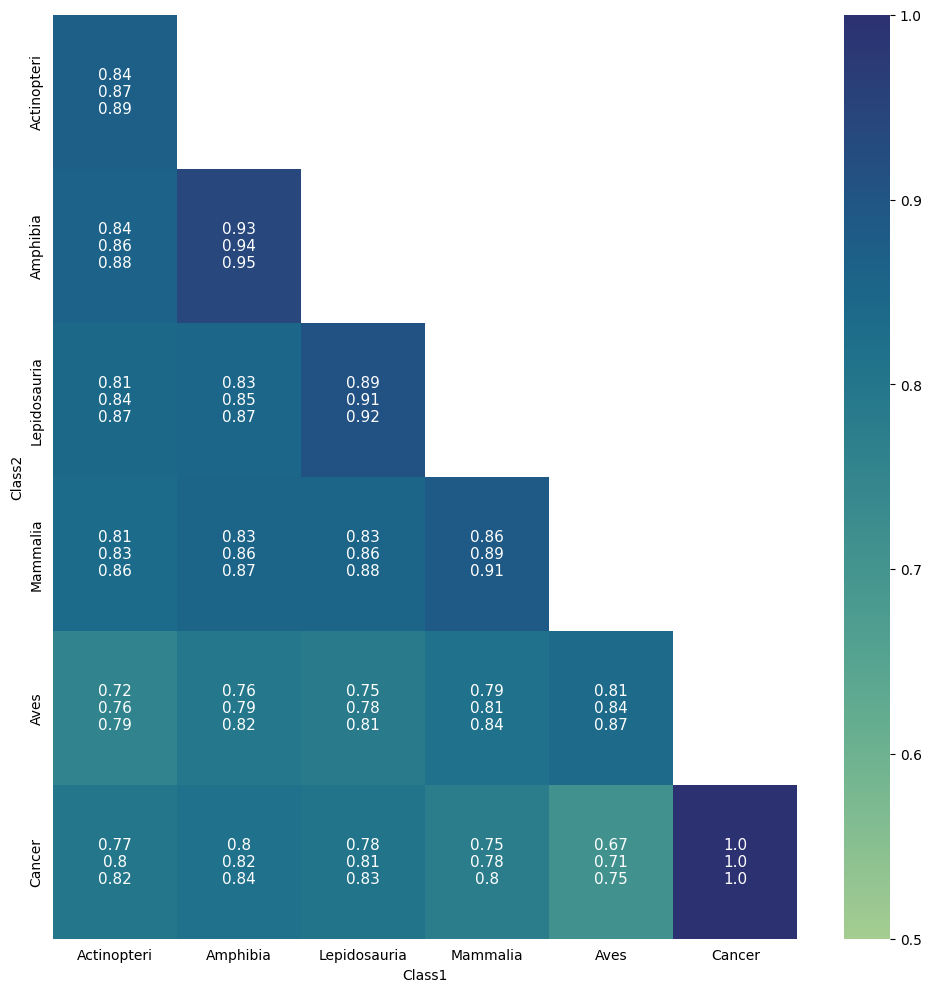

In [63]:
to_heatmap = pd.read_csv('../data/CosSimAll.csv')
heatmap_similaruty(to_heatmap, save_path='../pictures/HeatmapJack/Jackknife_Similarity.pdf', title='')

### JackKnife for transitions only

In [64]:
get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='TS', n_iter=1000, save_file_path='../data/CosSimTS.csv')

,Class1,Class2,Similarity
0,Actinopteri,Actinopteri,0.918105
1,Actinopteri,Actinopteri,0.823460
2,Actinopteri,Actinopteri,0.817731
3,Actinopteri,Actinopteri,0.803137
4,Actinopteri,Actinopteri,0.930830
...,...,...,...
20995,Cancer,Cancer,0.996877
20996,Cancer,Cancer,0.992081
20997,Cancer,Cancer,0.998085
20998,Cancer,Cancer,0.996353


/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_7500/1036068666.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_quantile_annot[cls1][cls2] = ''.join(res_txt)


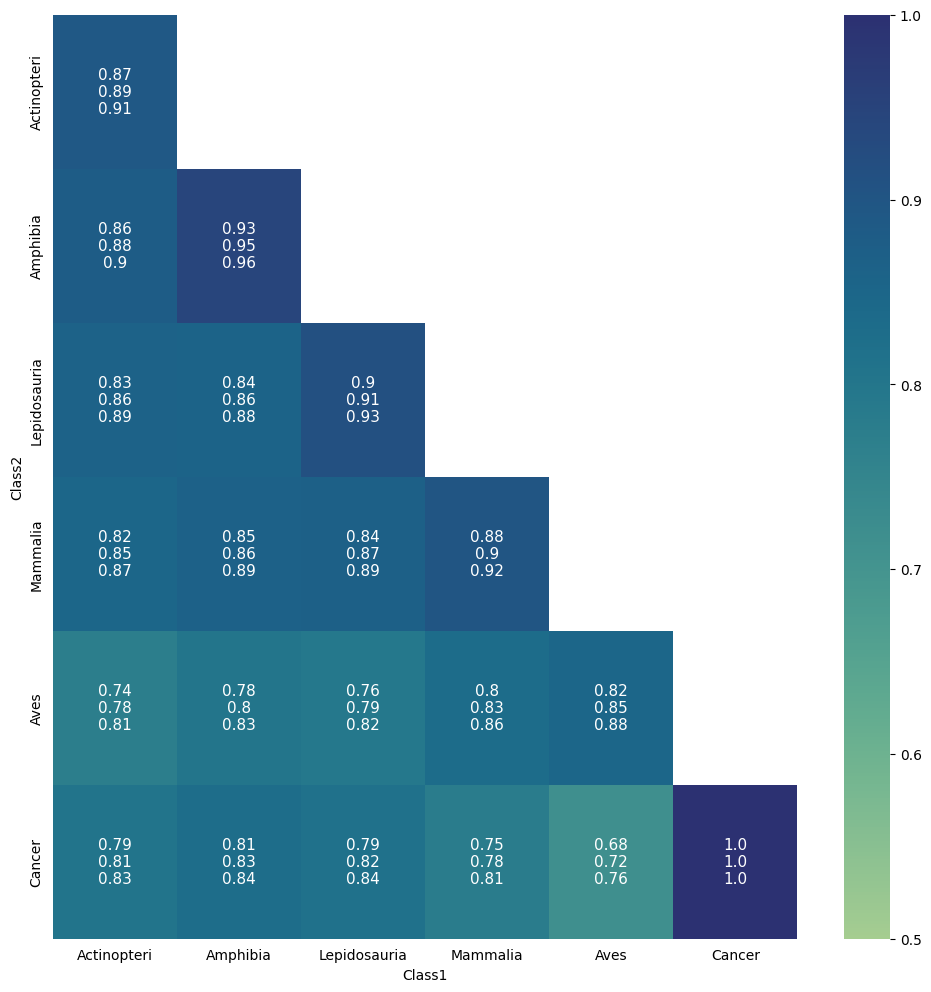

In [65]:
to_heatmap = pd.read_csv('../data/CosSimTS.csv')
heatmap_similaruty(to_heatmap, save_path= '../pictures/HeatmapJack/Jackknife_SimilarityTS.pdf', title = '')

### JackKnife for transversions only

In [66]:
get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='TV', n_iter=1000, save_file_path='../data/CosSimTV.csv')

,Class1,Class2,Similarity
0,Actinopteri,Actinopteri,0.504760
1,Actinopteri,Actinopteri,0.500431
2,Actinopteri,Actinopteri,0.271596
3,Actinopteri,Actinopteri,0.610049
4,Actinopteri,Actinopteri,0.360262
...,...,...,...
20995,Cancer,Cancer,0.988909
20996,Cancer,Cancer,0.988359
20997,Cancer,Cancer,0.980943
20998,Cancer,Cancer,0.984475


/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_7500/1036068666.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_quantile_annot[cls1][cls2] = ''.join(res_txt)


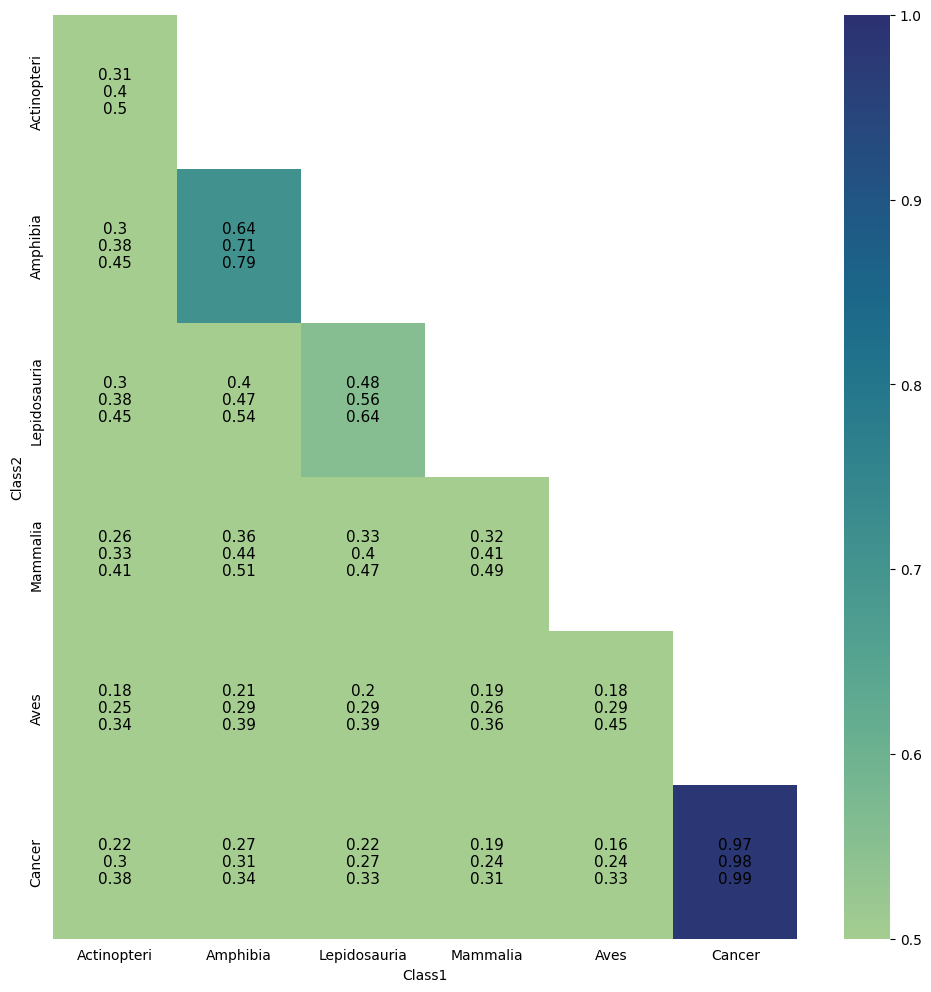

In [67]:
to_heatmap = pd.read_csv('../data/CosSimTV.csv')
heatmap_similaruty(to_heatmap, save_path='../pictures/HeatmapJack/Jackknife_SimilarityTV.pdf', title='', col_ht='black')

### Jackknife for 4 types of substituion in transitions only!

In [68]:
vec_of_subs_het = ['C>T', 'A>G', 'G>A', 'T>C']
TS_cancer = canc_df[canc_df['MutBase'].isin(TS_vec)]
TS_df = mut[mut['MutBase'].isin(TS_vec)].copy()
for sub in vec_of_subs_het:
    needed_subs_df = TS_df[TS_df['MutBase'] == sub]
    cancer_needed_subs = TS_cancer[TS_cancer['MutBase'] == sub]
    get_similarity_table(mut_df=needed_subs_df, canc_df=cancer_needed_subs, mut_type='all', n_iter=1000, save_file_path=f'../data/CosSim{sub}.csv')
    

KeyboardInterrupt: 

In [ ]:
for sub in vec_of_subs_het:
    to_heatmap = pd.read_csv(f'../data/CosSim{sub}.csv')
    heatmap_similaruty(to_heatmap, save_path=f'../pictures/HeatmapJack/Jackknife_Similarity{sub}.pdf', title=sub)